In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import scanpy as sc
import anndata as ad
import h5py  
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats
from utils import MMD, LISI, random_forest, norm_total
import pandas as pd
import muon as mu

import sys
sys.path.append('/stor/lep/workspace/scdiffusion_v2')
from model import VQModel

/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


# CFGen

load real data

In [2]:
# mdata = mu.read_h5mu('/stor/lep/data/pbmc10k_multiome/cfgen/pbmc10k_multiome_test.h5mu')
mdata = mu.read_h5mu('/stor/lep/diffusion/multiome/openproblem_filtered.h5mu')
# mdata = mu.read_h5mu('/stor/lep/diffusion/multiome/openproblems_2500gene_03atac_full.h5mu')
# mdata = mu.read_h5mu('/stor/lep/data/BABEL/train.h5mu')
real_cell = mdata['rna'][::10].X.toarray()#[:1700] layers['X_counts'].toarray()
real_cell2 = mdata['atac'][::10].X.toarray()#[:1700] layers['X_counts'].toarray()
# real_cell = mdata['rna'][mdata['rna'].obs['cell_type']=='CD4+ T activated'].X.toarray()[::7]
# real_cell2 = mdata['atac'][mdata['atac'].obs['cell_type']=='CD4+ T activated'].X.toarray()[::7]
real_cell.shape

/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/mudata/_core/mudata.py:1454: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/mudata/_core/mudata.py:960: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_common = pd.concat(
/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/mudata/_core/mudata.py:1352: FutureWarning: From 0.4 .update() wi

(6925, 13431)

load cfgen data

In [3]:
# npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_joint_2/covariate_indices_big.npz')
npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_small_full_joint/covariate_indices_big.npz')
index = npzfile['data'][:9600]#[:20700]

# npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_pbmc10k_joint/RNA_condi.npz')
# npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_small_full_joint/RNA_condi_big.npz')
npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_joint_2/RNA_condi_big.npz')
reconstruct = npzfile['data'][:real_cell.shape[0]]
# reconstruct = npzfile['data'][np.where(index==3)][:real_cell.shape[0]]

# npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_pbmc10k_joint/ATAC_condi.npz')
# npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_small_full_joint/ATAC_condi_big.npz')
npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_joint_2/ATAC_condi_big.npz')
reconstruct2 = npzfile['data'][:real_cell.shape[0]]
# reconstruct2 = npzfile['data'][np.where(index==3)][:real_cell.shape[0]]
# reconstruct = norm_total(reconstruct)
reconstruct.shape

(6925, 13431)

evaluation metrics

In [4]:
print('RNA')
print(real_cell.mean())
print(reconstruct.mean())
print('spearman=',stats.spearmanr(real_cell.mean(axis=0), reconstruct.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(real_cell.mean(axis=0), reconstruct.mean(axis=0))[0][1])
print(np.mean((reconstruct-real_cell)**2))
print(np.linalg.norm(reconstruct.mean(axis=0)-real_cell.mean(axis=0)))

print('ATAC')
print(real_cell2.mean())
print(reconstruct2.mean())
print('spearman=',stats.spearmanr(real_cell2.mean(axis=0), reconstruct2.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(real_cell2.mean(axis=0), reconstruct2.mean(axis=0))[0][1])
print(np.mean((reconstruct2-real_cell2)**2))
print(np.linalg.norm(reconstruct2.mean(axis=0)-real_cell2.mean(axis=0)))

RNA
0.14379396
0.14813936
spearman= 0.9898997969842187
pearson= 0.9928930395291983
7.061178
9.845005
ATAC
0.07920893
0.075245075
spearman= 0.974131755789137
pearson= 0.9958416670116891
0.13134661
1.6063135


In [14]:
print('RNA')
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
print('AUC = ', random_forest(adata))

print('\nATAC')
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
print('AUC = ', random_forest(adata))

RNA


/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
100%|██████████| 70/70 [00:14<00:00,  4.67it/s]


MMD =  tensor(0.0060)


/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


LISI =  0.8261360646585141
AUC =  0.7308657030251442

ATAC


/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
100%|██████████| 70/70 [00:14<00:00,  4.69it/s]


MMD =  tensor(0.0103)


/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


LISI =  0.8931625727848567
AUC =  0.6301106177570118


RNA


/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(



ATAC


/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


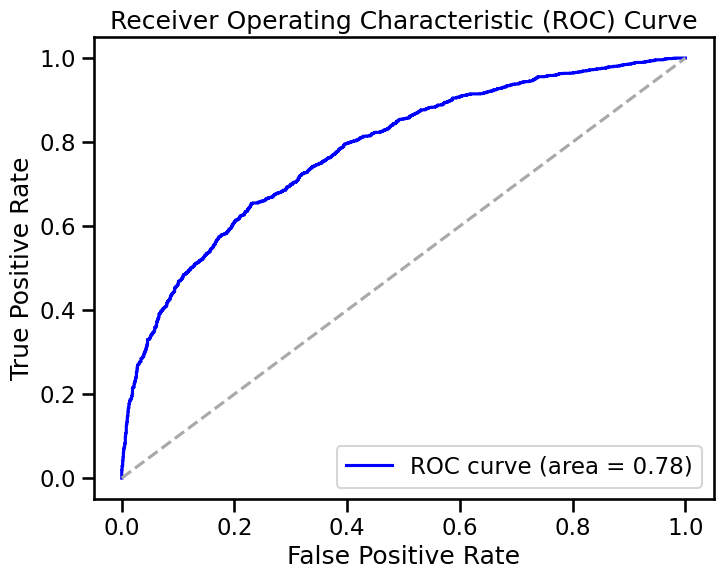

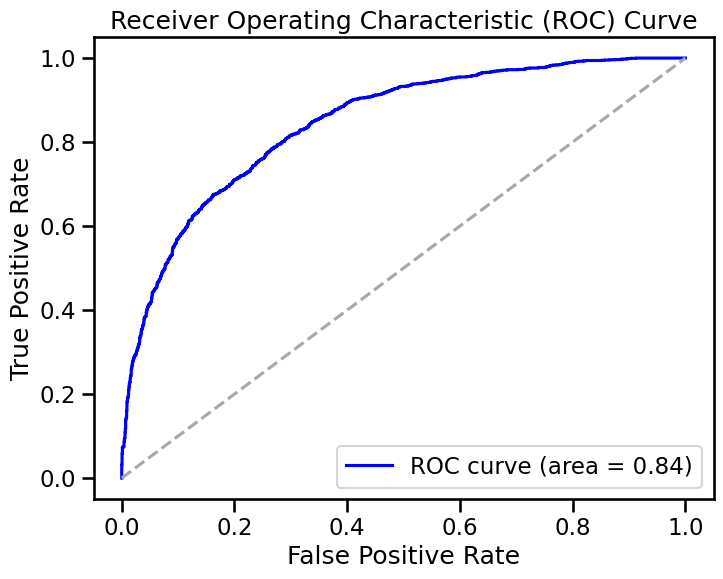

In [7]:
print('RNA')
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
aucval, fpr_Nb, tpr_Nb = random_forest(adata,True)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(8, 6))
plt.plot(fpr_Nb, tpr_Nb, color='blue', label='ROC curve (area = %0.2f)' % aucval)
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/eval_metrics/AUC_curve/cfgen_rna.pdf')


print('\nATAC')
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
aucval, fpr_Nb, tpr_Nb = random_forest(adata,True)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(8, 6))
plt.plot(fpr_Nb, tpr_Nb, color='blue', label='ROC curve (area = %0.2f)' % aucval)
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/eval_metrics/AUC_curve/cfgen_atac.pdf')

/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


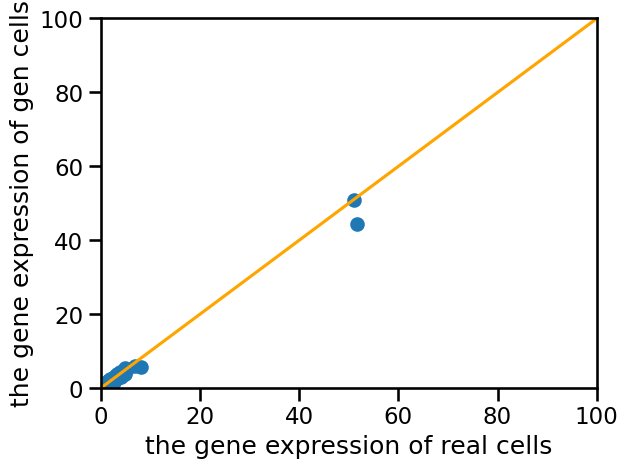

In [5]:
plt.figure()
lim = 100
plt.ylim((-0,lim))
plt.xlim((-0,lim))
plt.ylabel('the gene expression of gen cells')
plt.xlabel('the gene expression of real cells')
plt.scatter(real_cell.mean(axis=0),reconstruct.mean(axis=0))
# plt.scatter(np.expm1(cell_data).mean(axis=0),np.expm1(cell_gen).mean(axis=0))
plt.plot([0,lim],[0,lim],color='orange')

/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


<Axes: title={'center': 'cell_name'}, xlabel='UMAP1', ylabel='UMAP2'>

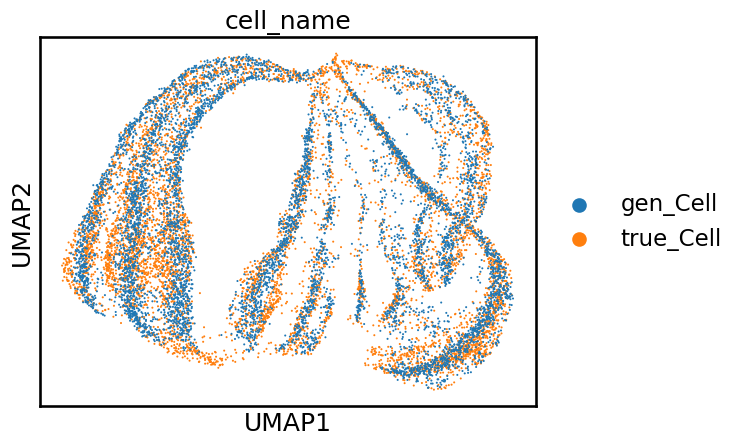

In [6]:
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
# adata.var_names = gene_names
adata.obs['cell_name'] = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]

# Perform PCA
sc.tl.pca(adata)
# Compute the neighborhood graph
sc.pp.neighbors(adata)
# Compute UMAP
sc.tl.umap(adata)

sc.pl.umap(adata, color="cell_name", show=False)

/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


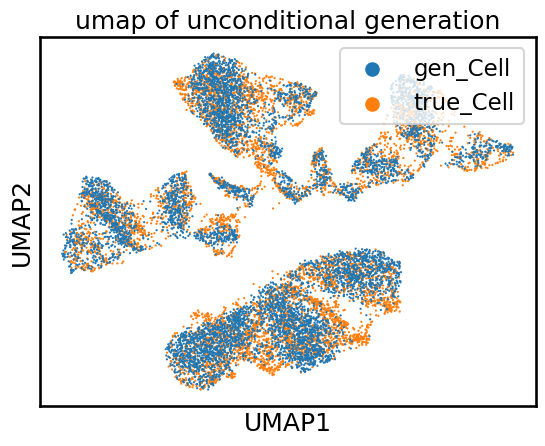

In [7]:
# # 再转回anndata便于scanpy处理
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
# adata.var_names = gene_names
adata.obs['cell_name'] = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.pl.umap(adata, color='cell_name', size=10, title='umap of unconditional generation', show=False)
plt.legend(loc = 'upper right')
# plt.savefig(f'/data1/lep/Workspace/guided-diffusion/figure_pdf_new/pbmc_umap_uncondi.pdf')

# scDesign3

In [112]:
# adata_rna = sc.read_h5ad('/stor/lep/diffusion/multiome/openproblems_RNA_filterd_2500.h5ad')
# adata_atac = sc.read_h5ad('/stor/lep/diffusion/multiome/openproblems_ATAC_filterd_03.h5ad')
adata_rna = sc.read_h5ad('/stor/lep/data/pbmc10k_multiome/cfgen/pbmc10k_multiome_all_rna_2500.h5ad')
adata_atac = sc.read_h5ad('/stor/lep/data/pbmc10k_multiome/cfgen/pbmc10k_multiome_all_atac_006.h5ad')

In [113]:
# sample_id = np.random.choice(adata_rna.shape[0],8000,replace=False)
real_cell = adata_rna[:8000].X.toarray()
real_cell2 = adata_atac[:8000].X.toarray()

In [114]:
file_path = '/stor/lep/workspace/multi_diffusion/scDesign3/output/sim_pbmc_RNA.h5'
h5_file= h5py.File(file_path, 'r')
file_path = '/stor/lep/workspace/multi_diffusion/scDesign3/output/sim_pbmc_ATAC.h5'
h5_file2= h5py.File(file_path, 'r')

reconstruct = np.array(h5_file['group']['matrix'])[::2]
reconstruct2 = (np.array(h5_file2['group']['matrix'])>0).astype(np.float32)[::2]
reconstruct2.shape

In [76]:
from tqdm import tqdm
cell_type1 = []
scdesign_obs_names = np.array(h5_file['group']['colnames'])
for i in tqdm(range(scdesign_obs_names.shape[0])):
    if i<scdesign_obs_names.shape[0]/2:
        cell_type1.append(adata_rna[scdesign_obs_names[i].decode('utf-8')].obs['cell_type'].values[0])
    else:
        break
cell_type1 = cell_type1 + cell_type1

 50%|█████     | 5000/10000 [00:22<00:22, 224.45it/s]


In [115]:
print('RNA')
print(real_cell.mean())
print(reconstruct.mean())
print('spearman=',stats.spearmanr(real_cell.mean(axis=0), reconstruct.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(real_cell.mean(axis=0), reconstruct.mean(axis=0))[0][1])
print(np.mean((reconstruct-real_cell)**2))
print(np.linalg.norm(reconstruct.mean(axis=0)-real_cell.mean(axis=0)))

print('ATAC')
print(real_cell2.mean())
print(reconstruct2.mean())
print('spearman=',stats.spearmanr(real_cell2.mean(axis=0), reconstruct2.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(real_cell2.mean(axis=0), reconstruct2.mean(axis=0))[0][1])
print(np.mean((reconstruct2-real_cell2)**2))
print(np.linalg.norm(reconstruct2.mean(axis=0)-real_cell2.mean(axis=0)))

RNA
0.1788754
0.1799667
spearman= 0.9836283571998632
pearson= 0.999799299914606
2.1583384
0.7313600569407698
ATAC
0.3904556
0.31684896
spearman= 0.9949946128886892
pearson= 0.9938016549740183
0.44586086
7.5857434


In [116]:
print('RNA')
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
print('AUC = ', random_forest(adata))

print('\nATAC')
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
print('AUC = ', random_forest(adata))

RNA


/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
100%|██████████| 81/81 [00:22<00:00,  3.60it/s]


MMD =  tensor(0.0038)


/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


LISI =  0.8892157130322218
AUC =  0.6540122560768401

ATAC


/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
100%|██████████| 81/81 [00:24<00:00,  3.34it/s]


MMD =  tensor(0.5261)


/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


LISI =  0.13190896247714834
AUC =  0.974485635604886


# evaluate autoencoder

In [3]:
import muon as mu
from muon import MuData
import yaml
from scvi.distributions import NegativeBinomial
from torch.distributions import Poisson, Bernoulli

sys.path.append('/stor/lep/workspace/multi_diffusion/CFGen/cfgen')
from models.base.encoder_model import EncoderModel

/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/lightning/fabric/__init__.py:40: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/pkg_resources/__init__.py:3117: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/lightning/fabric/__init__.py:40: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pac

In [118]:
# encoder_config = "encoder_multimodal"
# dataset_path = '/stor/lep/diffusion/multiome/openproblems_2500gene_03atac.h5mu'#"/stor/lep/data/BABEL/all.h5mu"
# covariate_keys = "cell_type" #"leiden"
# num_class = 22 #33
# # ae_path = "/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_babel_multimodal/checkpoints/epoch_39.ckpt"
# ae_path = "/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_openproblem_multimodal_2500_03/checkpoints/last.ckpt"
encoder_config = "encoder_multimodal"
dataset_path = "/stor/lep/data/BABEL/train.h5mu"
covariate_keys = "leiden"
num_class = 34 #36
ae_path = "/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_babel_multimodal_wd1e4_tfidt_normalsize/checkpoints/last.ckpt"

In [119]:
mdata = mu.read_h5mu(dataset_path)
real_cell = mdata['rna'][::10].X.toarray()# layers['X_counts'].toarray()
real_cell2 = mdata['atac'][::10].X.toarray()

/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/mudata/_core/mudata.py:1454: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/mudata/_core/mudata.py:1352: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [120]:
with open(f'{os.getcwd()}/../../CFGen/configs/configs_encoder/encoder/{encoder_config}.yaml', 'r') as file:
    yaml_content = file.read()
autoencoder_args = yaml.safe_load(yaml_content)

# Initialize encoder                'atac': 143810, 'rna': 19448
encoder_model = EncoderModel(in_dim={'atac': real_cell2.shape[1], 'rna': real_cell.shape[1]},
                                    n_cat=mdata['rna'].obs[covariate_keys].unique().shape[0],
                                    conditioning_covariate=covariate_keys, 
                                    encoder_type='learnt_autoencoder',
                                    **autoencoder_args)

# Load weights 
# encoder_model.load_state_dict(torch.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_openproblem_multimodal_fixed/checkpoints/last.ckpt')["state_dict"])
encoder_model.load_state_dict(torch.load(ae_path)["state_dict"])
encoder_model.eval()

EncoderModel(
  (encoder): ModuleDict(
    (rna): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=34861, out_features=512, bias=True)
          (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=300, bias=True)
          (1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=300, out_features=100, bias=True)
      )
    )
    (atac): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=223897, out_features=1024, bias=True)
          (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=1024, out_features=512, bias=True)
          (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (2): ELU(alp

In [121]:
mdata_r = mu.read(dataset_path, backed=True)
# mdata_r = mu.read('/stor/lep/data/pbmc10k_multiome/pbmc10k.h5mu', backed=True)
batch = {}
# index = list(range(0,69200,10))
# index = list(range(0,10000,2))
index = list(range(0,mdata_r['rna'].shape[0],10))
batch["X_norm"] = {'rna':torch.tensor(mdata_r['rna'][index].X.toarray()),'atac':torch.tensor(mdata_r['atac'][index].X.toarray())}

/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/mudata/_core/mudata.py:1454: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/mudata/_core/mudata.py:1352: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [122]:
X = {mod: torch.tensor(batch["X_norm"][mod]).to(encoder_model.device) for mod in batch["X_norm"]}
size_factor = {}
for mod in X:
    size_factor_mod = X[mod].sum(1).unsqueeze(1).to(encoder_model.device)
    size_factor[mod] = size_factor_mod

z = encoder_model.encode(batch)
mu_hat = encoder_model.decode(z, size_factor)

/tmp/ipykernel_242187/2478056688.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = {mod: torch.tensor(batch["X_norm"][mod]).to(encoder_model.device) for mod in batch["X_norm"]}


In [123]:
sample = {}  # containing final samples 
for mod in mu_hat:
    if mod=="rna":  
        # if not self.covariate_specific_theta:
        distr = NegativeBinomial(mu=mu_hat[mod], theta=torch.exp(encoder_model.theta))
        # else:
        #     distr = NegativeBinomial(mu=mu_hat[mod], theta=torch.exp(encoder_model.theta[covariate_indices[theta_covariate]]))
    else:  # if mod is atac
        if not encoder_model.is_binarized:
            distr = Poisson(rate=mu_hat[mod])
        else:
            distr = Bernoulli(probs=mu_hat[mod])
    sample[mod] = distr.sample() 
reconstruct = sample['rna'].detach().numpy()
reconstruct2 = sample['atac'].detach().numpy()

reconstruct.shape

(2837, 34861)

In [113]:
z['rna'].shape,z['atac'].shape

(torch.Size([5000, 100]), torch.Size([5000, 100]))

In [36]:
z['rna'].std(0).mean(),z['atac'].std(0).mean()

(tensor(1.7983, grad_fn=<MeanBackward0>),
 tensor(4.8659, grad_fn=<MeanBackward0>))

In [38]:
z['rna'].mean(),(z['rna']/15.726).std(0).mean(),z['atac'].mean(),(z['atac']/31.398).std(0).mean()

(tensor(-0.0295, grad_fn=<MeanBackward0>),
 tensor(0.1000, grad_fn=<MeanBackward0>),
 tensor(-0.2314, grad_fn=<MeanBackward0>),
 tensor(0.1000, grad_fn=<MeanBackward0>))

In [124]:
print('RNA')
# reconstruct = mu_hat['rna'].detach().numpy()
real_cell = batch["X_norm"]['rna'].detach().numpy()
print(real_cell.mean())
print(reconstruct.mean())
print('spearman=',stats.spearmanr(real_cell.mean(axis=0), reconstruct.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(real_cell.mean(axis=0), reconstruct.mean(axis=0))[0][1])
print(np.mean((reconstruct-real_cell)**2))
print(np.linalg.norm(reconstruct.mean(axis=0)-real_cell.mean(axis=0)))
print('\n')

print('ATAC')
# reconstruct2 = mu_hat['atac'].detach().numpy()
real_cell2 = batch["X_norm"]['atac'].detach().numpy()
print(real_cell2.mean())
print(reconstruct2.mean())
print('spearman=',stats.spearmanr(real_cell2.mean(axis=0), reconstruct2.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(real_cell2.mean(axis=0), reconstruct2.mean(axis=0))[0][1])
print(np.mean((reconstruct2-real_cell2)**2))
print(np.linalg.norm(reconstruct2.mean(axis=0)-real_cell2.mean(axis=0)))

RNA
0.33260924
0.33264083
spearman= 0.9905749529158486
pearson= 0.9996396062427291
1.5231049
8.997425


ATAC
0.012177916
0.015873078
spearman= 0.9609200786613972
pearson= 0.9674939280726194
0.021272656
4.2234817


In [54]:
import sklearn.metrics as metrics

print('AUROC for ATAC data')
truth = real_cell2.flatten()
# preds = mu_hat['atac'][mdata['rna'].obs['batch']=='train'].detach().numpy()[::8].flatten()
preds = mu_hat['atac'].detach().numpy().flatten()
# preds = reconstruct2.flatten()
fpr, tpr, _thresholds = metrics.roc_curve(truth, preds)
auc = metrics.auc(fpr, tpr)
print(auc)

AUROC for ATAC data
0.9602598608551244


In [ ]:
AUROC for ATAC data
0.9389488239372237
0.9918862160909309

In [125]:
print('RNA')
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
print('AUC = ', random_forest(adata))
print('\n')

print('ATAC')
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
print('AUC = ', random_forest(adata))

RNA


/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
100%|██████████| 29/29 [00:03<00:00,  9.51it/s]


MMD =  tensor(0.0008)


/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


LISI =  0.9387004076233949
AUC =  0.5515502628473339


ATAC


/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
100%|██████████| 29/29 [00:02<00:00, 12.01it/s]


MMD =  tensor(0.0978)


/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


LISI =  0.8456185295693399
AUC =  0.80633138234254


In [ ]:
MMD =  tensor(0.0106)
LISI =  0.9167445852683156
AUC =  0.7705738138095182

In [ ]:
MMD =  tensor(0.0007)
LISI =  0.9428611304410977
AUC =  0.5198377220692423

MMD =  tensor(0.0005)
LISI =  0.9634232141296801
AUC =  0.46614574020431765

In [15]:
adata_real = sc.read_h5ad('/stor/lep/diffusion/multiome/openproblems_RNA_new.h5ad')
# adata_real = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/data/tabula_muris/all.h5ad')

celltype = adata_real.obs['cell_type'].values[:69000][::10]

/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/lep/miniconda3/envs/evaluate_env/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 100 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


<Axes: title={'center': 'umap of unconditional generated latent'}, xlabel='UMAP1', ylabel='UMAP2'>

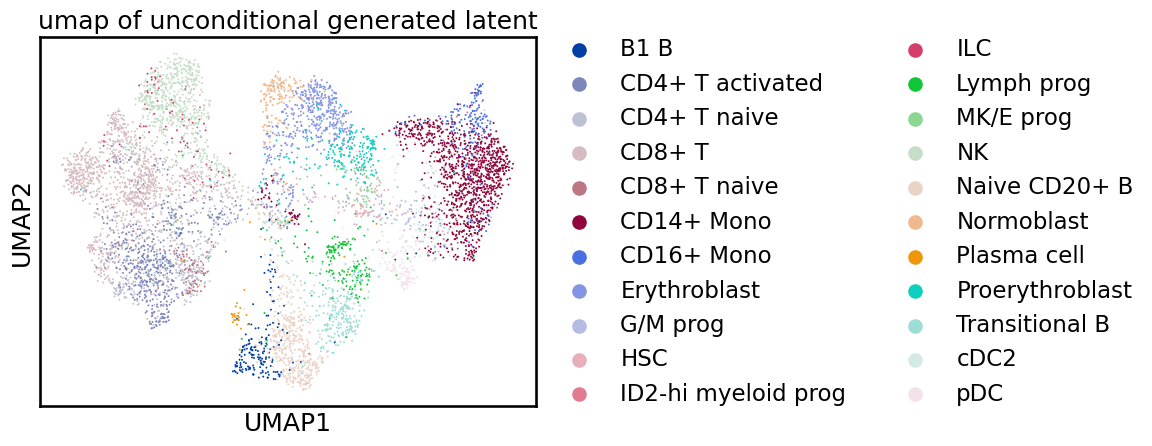

In [75]:
adata = ad.AnnData(z['atac'].detach().numpy(), dtype=np.float32)

adata.obs['cell_name'] = celltype

# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# adata.raw = adata
# adata = adata[:, adata.var.highly_variable]

# sc.pp.scale(adata)
# sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.pl.umap(adata, color='cell_name', size=8, title='umap of unconditional generated latent', show=False)
# plt.legend(loc = 'upper right')

In [76]:
from sklearn.metrics import adjusted_rand_score

sc.tl.leiden(adata)
true_labels = adata.obs['cell_name']  
predicted_labels = adata.obs['leiden'] 
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari_score}")

Adjusted Rand Index (ARI): 0.46203605014744625
